# Project 3: Understanding User Behavior

## Project Overview

***
### Project Context

- You're a data scientist at a game development company  

- Your latest mobile game has two events you're interested in tracking: `buy
  sword` & `join guild`

- Each has metadata characterstic of such events (i.e., sword type, guild name,
  etc)


### Pipeline and Tools

- Flask API server to log events to Kafka. Uses game_api.py

- Outlined below is how to assemble the data pipeline to catch these events: for batch processing and analysis with Spark sql and using Spark streaming to filter select event types from Kafka, land them into HDFS/parquet to make them available for analysis using Presto. 

- Apache Bench and bash script to generate test data for the pipeline.

- Some basic analysis of the events generated in a sample of data pipeline use for batch and stream processing. 

## Pipeline and Cluster Set Up
*** 

### Spin up cluster
```
docker-compose up -d
```
*** 

### Create Kafka Events Topic
```
docker-compose exec kafka kafka-topics --create --topic events --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```
*** 
### Run Flask
```
docker-compose exec mids env FLASK_APP=/w205/project-3-Cuffnela/game_api.py flask run --host 0.0.0.0
```
*** 
### Generate Events with Apache Bench

#### Default
```
docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/
```

#### Buy Swords
```
docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/buy_sword/dagger

docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/buy_sword/longsword
```

#### Join Guilds 
```
docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/join_guild/Sea_of_Sorrows

docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/join_guild/Henge_of_Denravi

docker-compose exec mids ab -n 10 -H "Host: user1.comcast.com" http://localhost:5000/join_guild/Gates_of_Madness
```

#### Infinite Loop for streaming
The bash script `random_streaming_events.sh` randomly generates between 1 and 10 of a randomly selected event with an randomly selected user.  
```
while true; do ./random_streaming_events.sh; sleep 5; done
```

*** 
### Shutdown Cluster
```
docker-compose down
```
*** 


# Batch Data Ingestion

## Filter Events and Write Parquet 
The Python code below extracts events from the kafka events topic and filters by event_type. Filtered purchase and guild event data are then written to HDFS in Parquet format. This code is intended for batch processing data. 

In [7]:
"""Extract events from kafka and write them to hdfs
"""
import json
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf


@udf('boolean')
def is_purchase(event_as_json):
    event = json.loads(event_as_json)
    if event['event_type'] == 'buy_sword':
        return True
    return False

@udf('boolean')
def is_guild(event_as_json):
    event = json.loads(event_as_json)
    if event['event_type'] == 'join_guild':
        return True
    return False

raw_events = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:29092") \
    .option("subscribe", "events") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

# filter and write buy sword events
purchase_events = raw_events \
    .select(raw_events.value.cast('string').alias('raw'),
            raw_events.timestamp.cast('string')) \
    .filter(is_purchase('raw'))

extracted_purchase_events = purchase_events \
    .rdd \
    .map(lambda r: Row(timestamp=r.timestamp, **json.loads(r.raw))) \
    .toDF()
extracted_purchase_events.printSchema()
extracted_purchase_events.show(5)

extracted_purchase_events \
    .write \
    .mode('overwrite') \
    .parquet('/tmp/purchases')

# filter and write join guild events
guild_events = raw_events \
    .select(raw_events.value.cast('string').alias('raw'),
            raw_events.timestamp.cast('string')) \
    .filter(is_guild('raw'))

extracted_guild_events = guild_events \
    .rdd \
    .map(lambda r: Row(timestamp=r.timestamp, **json.loads(r.raw))) \
    .toDF()
extracted_guild_events.printSchema()
extracted_guild_events.show(5)

extracted_guild_events \
    .write \
    .mode('overwrite') \
    .parquet('/tmp/guilds')


root
 |-- Accept: string (nullable = true)
 |-- Host: string (nullable = true)
 |-- User-Agent: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- sword_type: string (nullable = true)
 |-- timestamp: string (nullable = true)

+------+-----------------+---------------+----------+----------+--------------------+
|Accept|             Host|     User-Agent|event_type|sword_type|           timestamp|
+------+-----------------+---------------+----------+----------+--------------------+
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2

## PySpark and Read Parquet
Read HDFS parquet files and create temporary external tables table to use for querying data. This cluster uses Cloudera hadoop. These tables can be viewed in cloudera using the command below. 
```
docker-compose exec cloudera hadoop fs -ls /tmp/
```

### Purchases Table
The table contains data for all `buy_sword` events.

In [8]:
purchases = spark.read.parquet('/tmp/purchases')
purchases.show(10)
purchases.registerTempTable('purchases')

+------+-----------------+---------------+----------+----------+--------------------+
|Accept|             Host|     User-Agent|event_type|sword_type|           timestamp|
+------+-----------------+---------------+----------+----------+--------------------+
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword|    dagger|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword| longsword|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3| buy_sword| longsword|2021-04-13 00:00:...|
|   */*|    user1.att.com|ApacheBench/2.3| buy_sword| 

### Guilds Table
The table contains data for all `join_guild` events.

In [9]:
guilds = spark.read.parquet('/tmp/guilds')
guilds.show(10)
guilds.registerTempTable('guilds')

+------+-------------+---------------+----------+----------------+--------------------+
|Accept|         Host|     User-Agent|event_type|      guild_name|           timestamp|
+------+-------------+---------------+----------+----------------+--------------------+
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user1.att.com|ApacheBenc

## Querying Batch Game Data with SQL
Below are example queries of game data. 

### What is the most popular sword bought by users?
In the sample run of the game api more users purchased daggers.

In [19]:
sword_count = spark.sql("select count(*) as number, sword_type from purchases group by sword_type order by number desc")
sword_count.show()

+------+----------+
|number|sword_type|
+------+----------+
|    39|    dagger|
|    24| longsword|
+------+----------+



### How many times did host 'user1.comcast.com' join each of the guilds?

In [26]:
guild_joins_by_user1 = spark.sql("select count(host) as number_times_joined," 
                               "guild_name from guilds where Host = 'user1.comcast.com'"
                               "group by guild_name order by number_times_joined desc")
guild_joins_by_user1.show(5)

+-------------------+----------------+
|number_times_joined|      guild_name|
+-------------------+----------------+
|                 35|Henge_of_Denravi|
|                 30|Gates_of_Madness|
|                 11|  Sea_of_Sorrows|
+-------------------+----------------+



### What is the most popular Guild? 
In the sample game data Gates of Madness is the most popular guild, followed closely by Henge of Denravi. Sea of Sorrows is noticably less popular than the other two guilds.

In [33]:
guild_totals = spark.sql("select count(*) as total_joins, guild_name from guilds group by guild_name")
df = guild_totals.toPandas()

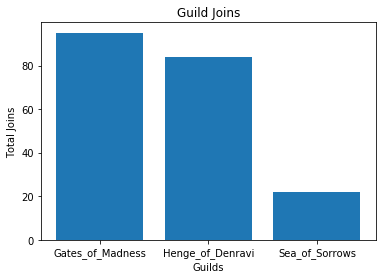

In [31]:
import matplotlib.pyplot as plt

plt.bar(df.guild_name,df.total_joins)
plt.title('Guild Joins')
plt.xlabel('Guilds')
plt.ylabel('Total Joins')
plt.show()

### What this the average number of joins for guilds?
In the sample game data there are an average of 67 joins per guild.

In [36]:
df.describe()

,total_joins
count,3.000000
mean,67.000000
std,39.357337
min,22.000000
25%,53.000000
50%,84.000000
75%,89.500000
max,95.000000


## Which user and event are the most common?

In [54]:
full_users = spark.sql("select * from purchases union select * from guilds")
full_users.show(15)
df_all = full_users.toPandas()

+------+-----------------+---------------+----------+----------------+--------------------+
|Accept|             Host|     User-Agent|event_type|      sword_type|           timestamp|
+------+-----------------+---------------+----------+----------------+--------------------+
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|user2.comcast.com|ApacheBench/2.3|join_guild|Henge_of_Denravi|2021-04-13 00:01:...|
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:04:...|
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:00:...|
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|  Sea_of_Sorrows|2021-04-13 00:01:...|
|   */*|user2.comcast.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13 00:02:...|
|   */*|    user1.att.com|ApacheBench/2.3|join_guild|Gates_of_Madness|2021-04-13

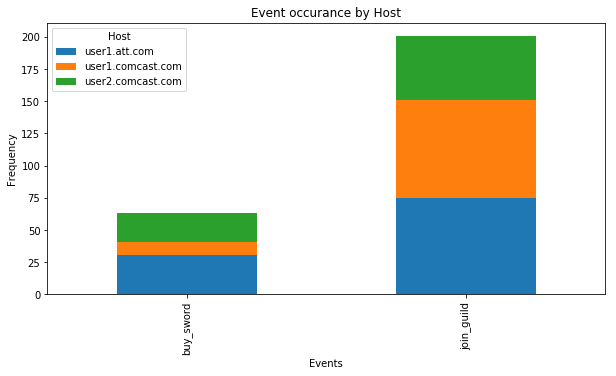

In [79]:
df_all.groupby(['event_type','Host']).size().unstack().plot(kind='bar',stacked = True,figsize=(10, 5))
plt.title('Event occurance by Host')
plt.xlabel('Events')
plt.ylabel('Frequency')
plt.show()

In [78]:
df_all.describe()

,Accept,Host,User-Agent,event_type,sword_type,timestamp
count,264,264,264,264,264,264
unique,1,3,1,2,5,264
top,*/*,user1.att.com,ApacheBench/2.3,join_guild,Gates_of_Madness,2021-04-13 00:01:43.988
freq,264,106,264,201,95,1


# Streaming Data Ingestion

## Filter Events and Write to HDFS
The Python code below extracts events from the kafka events topic and filters by event_type. Filtered purchase and guild event data are then written to HDFS in Parquet format. This code handles event data in streaming mode. 

In [1]:
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, from_json
from pyspark.sql.types import StructType, StructField, StringType

Define event schema.

In [2]:
def buy_sword_event_schema():
    """
    root
    |-- Host: string (nullable = true)
    |-- sword_type: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- Accept: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Host", StringType(), True),
        StructField("sword_type", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("Accept", StringType(), True),
        StructField("User-Agent", StringType(), True),
    ])

def join_guild_event_schema():
    """
    root
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- Accept: string (nullable = true)
    |-- guild_name: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("Accept", StringType(), True),
        StructField("guild_name", StringType(), True),
    ])

Boolean functions later used filter events by type and manage different schema between events.

In [3]:
@udf('boolean')
def is_sword_purchase(event_as_json):
    """udf for filtering purchase events
    """
    event = json.loads(event_as_json)
    if event['event_type'] == 'buy_sword':
        return True
    return False

@udf('boolean')
def is_join_guild(event_as_json):
    """udf for filtering guild events
    """
    event = json.loads(event_as_json)
    if event['event_type'] == 'join_guild':
        return True
    return False

Load data.

In [4]:
raw_events = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "kafka:29092") \
        .option("subscribe", "events") \
        .load()

Filter data by event type.

In [5]:
sword_purchases = raw_events \
        .filter(is_sword_purchase(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          buy_sword_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')

join_guilds = raw_events \
        .filter(is_join_guild(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          join_guild_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')   

Write streaming data to parquet. Triggers every 10 seconds.

In [6]:
sink_swords = sword_purchases \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_sword_purchases") \
        .option("path", "/tmp/sword_purchases") \
        .trigger(processingTime="10 seconds") \
        .start()
        
sink_guilds = join_guilds \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_join_guilds") \
        .option("path", "/tmp/join_guilds") \
        .trigger(processingTime="10 seconds") \
        .start()

Stop execution.

In [7]:
sink_swords.stop()
sink_guilds.stop()

## Creating External Tables with Hive
The code below creates external tables for both buy_sword events and join_guild events.

```
docker-compose exec cloudera hive

create external table if not exists default.sword_purchases (Raw string, timestamp string, Host string, sword_type string, event_type string, Accept string, User_Agent string) stored as parquet location '/tmp/sword_purchases'  tblproperties ("parquet.compress"="SNAPPY");

create external table if not exists default.join_guilds (Raw string, timestamp string, Host string, User_Agent string, event_type string, Accept string, guild_name string) stored as parquet location '/tmp/join_guilds'  tblproperties ("parquet.compress"="SNAPPY");

```

## Querying External Tables with Presto
Using the presto and sql we can query the external tables created above using streaming data. The output for the sql queries will change as they are rerun and more data is streamed to the external tables. 

```
docker-compose exec presto presto --server presto:8080 --catalog hive --schema default
```

### How many of each type of sword were purchased?
```
select count(Host) as total_bought, sword_type from sword_purchases group by sword_type;

 total_bought | sword_type 
--------------+------------
           11 | longsword  
           13 | dagger 
```

### How many guild joins occured for each guild?
```
select count(Host) as total_joins, guild_name  from join_guilds group by guild_name;
           
 total_joins |    guild_name    
-------------+------------------
          66 | Henge_of_Denravi 
          65 | Gates_of_Madness 
          19 | Sea_of_Sorrows   
```
